In [1]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer






In [2]:
df = pd.read_csv("C:/Users/Muhammed/Desktop/train.csv")

In [3]:
print(df.isnull().sum())

Polarity    0
title       0
text        0
dtype: int64


In [4]:
df.head()


,Polarity,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Polarity  1048575 non-null  int64 
 1   title     1048575 non-null  object
 2   text      1048575 non-null  object
dtypes: int64(1), object(2)
memory usage: 24.0+ MB


In [6]:
#df.describe()

,Polarity
count,1.048575e+06
mean,1.505614e+00
std,4.999687e-01
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,2.000000e+00
max,2.000000e+00


In [7]:
df.columns

Index(['Polarity', 'title', 'text'], dtype='object')

C:\Users\Muhammed\AppData\Local\Temp\ipykernel_6520\2509465458.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Polarity', data=df, palette='viridis')


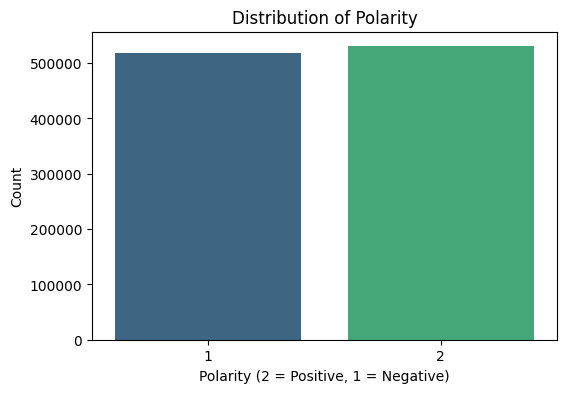

In [8]:
# 1. Polarity Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Polarity', data=df, palette='viridis')
plt.title("Distribution of Polarity")
plt.xlabel("Polarity (2 = Positive, 1 = Negative)")
plt.ylabel("Count")
plt.show()

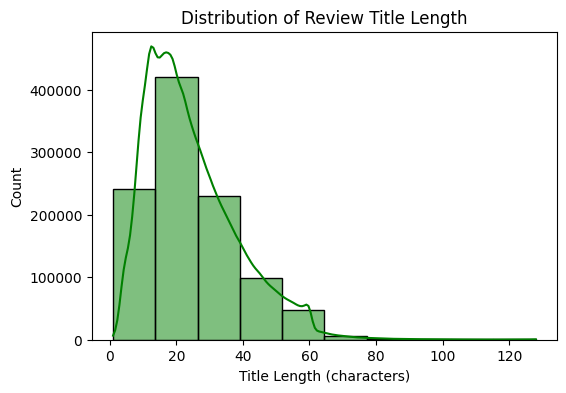

In [9]:
# 2. Title Length Analysis
df['title_length'] = df['title'].apply(len)
plt.figure(figsize=(6, 4))
sns.histplot(df['title_length'], bins=10, kde=True, color='green')
plt.title("Distribution of Review Title Length")
plt.xlabel("Title Length (characters)")
plt.ylabel("Count")
plt.show()

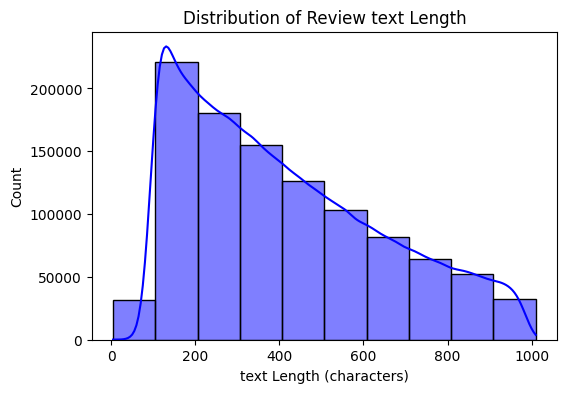

In [10]:
# 3. text Length Analysis
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(6, 4))
sns.histplot(df['text_length'], bins=10, kde=True, color='blue')
plt.title("Distribution of Review text Length")
plt.xlabel("text Length (characters)")
plt.ylabel("Count")
plt.show()

C:\Users\Muhammed\AppData\Local\Temp\ipykernel_6520\1337958992.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Polarity', y='text_length', data=df, palette='coolwarm')


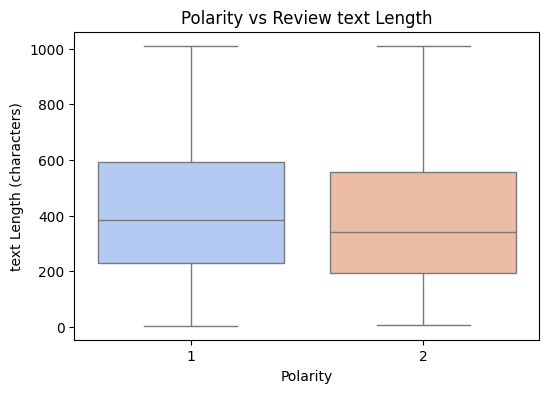

In [11]:
# 4. Polarity vs text Length
plt.figure(figsize=(6, 4))
sns.boxplot(x='Polarity', y='text_length', data=df, palette='coolwarm')
plt.title("Polarity vs Review text Length")
plt.xlabel("Polarity")
plt.ylabel("text Length (characters)")
plt.show()


In [12]:
# 5. Word Cloud for Positive and Negative Reviews
positive_text = " ".join(review for review in df[df.Polarity == 2].text)
negative_text = " ".join(review for review in df[df.Polarity == 1].text)

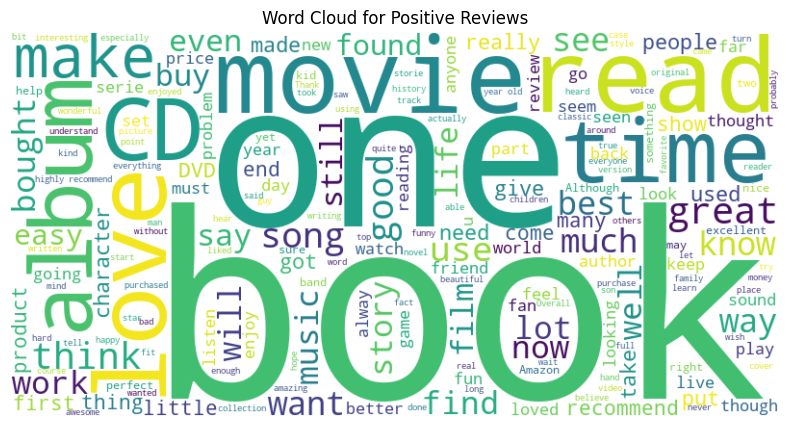

In [13]:
# 5.1. Generate Word Cloud for positive reviews
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()


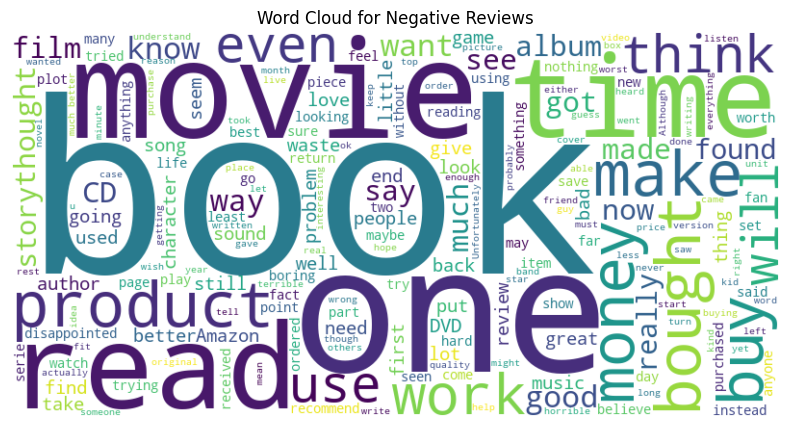

In [14]:
# 5.2. Generate Word Cloud for negative reviews
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()


In [29]:
# 6. Return Most Frequent Words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [word for word, idx in vec.vocabulary_.items()]
    
    return words_freq[:n]  


In [30]:
# 6.1. Most Common Words in Positive Reviews
positive_common_words = get_top_n_words(df[df.Polarity == 2]['text'], 10)
print("Most Common Words in Positive Reviews:", positive_common_words)

Most Common Words in Positive Reviews: ['reading', 'lot', 'of', 'reviews', 'saying', 'that', 'this', 'is', 'the', 'best']


In [31]:
# 6.2. Most Common Words in Negative Reviews
negative_common_words = get_top_n_words(df[df.Polarity == 1]['text'], 10)
print("Most Common Words in Negative Reviews:", negative_common_words)

Most Common Words in Negative Reviews: ['this', 'is', 'self', 'published', 'book', 'and', 'if', 'you', 'want', 'to']


In [32]:
# 7. Bigrams
def generate_ngrams(corpus, n=2):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    ngrams = [ngram for ngram, idx in vec.vocabulary_.items()]
    
    return ngrams  


In [33]:
# 7.1. Top bigrams in positive reviews
positive_bigrams = generate_ngrams(df[df.Polarity == 2]['text'], 2)
print("Most Common Bigrams in Positive Reviews:", positive_bigrams[:10])

Most Common Bigrams in Positive Reviews: ['reading lot', 'lot reviews', 'reviews saying', 'saying best', 'best game', 'game soundtrack', 'soundtrack figured', 'figured write', 'write review', 'review disagree']


In [34]:
# 7.2. Top bigrams in negative reviews
negative_bigrams = generate_ngrams(df[df.Polarity == 1]['text'], 2)
print("Most Common Bigrams in Negative Reviews:", negative_bigrams[:10])

Most Common Bigrams in Negative Reviews: ['self published', 'published book', 'book want', 'want know', 'know read', 'read paragraphs', 'paragraphs star', 'star reviews', 'reviews written', 'written ms']


In [47]:
def clean_text(text):
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    return text.lower()  

In [55]:
# 8. Sentiment by Title Keywords
def find_common_words(text_series, top_n=10):    
    cleaned_text_series = text_series.apply(clean_text)
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(cleaned_text_series)
    word_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))
    common_words = [word for word, _ in word_freq.most_common(top_n)]
    
    return common_words

In [56]:
# 8.1. Most common words in positive review titles
positive_title_words = find_common_words(df[df.Polarity == 2]['title'])
print("Most Common Words in Positive Titles:", positive_title_words)

Most Common Words in Positive Titles: ['great', 'good', 'book', 'best', 'excellent', 'movie', 'love', 'read', 'fun', 'classic']


In [57]:
# 8.2. Most common words in negative review titles
negative_title_words = find_common_words(df[df.Polarity == 1]['title'])
print("Most Common Words in Negative Titles:", negative_title_words)

Most Common Words in Negative Titles: ['book', 'good', 'dont', 'bad', 'money', 'buy', 'waste', 'movie', 'great', 'poor']


In [58]:
# 9. Top Positive and Negative Reviews by text Length
longest_positive_review = df[df.Polarity == 2].sort_values(by='text_length', ascending=False).iloc[0]
longest_negative_review = df[df.Polarity == 1].sort_values(by='text_length', ascending=False).iloc[0]

In [59]:
print("Longest Positive Review:", longest_positive_review['text'])
print("Longest Negative Review:", longest_negative_review['text'])

Longest Positive Review: This is one of my top few favorite albums. I have owned it for nearly six years now and the feelings conveyed are the same now as they were when it was new. The first twenty or so times I listened to it, I was confused and perhaps ashamed of some of the lyrics, but not anymore. The lyrics are without a doubt the best part of this music. Steele's vocalization of his words is truly unique and exquisite. I have rarely seen a songwriter who has so much to say and says it so well. He does not play games with you or get stifled by himself. I love this album because I assosicate it with so many raw emotions and experiences, and it never fails to take me back to places and times and people. Track number eight chokes me up every time and I hate that.The lyrics from Green Man read like Whitman and the melodies are many things at once. Beautiful, naked, dark, intelligent, and haunting all describe them perfectly. October Rust is as un-fluffy as anything can be and it has 

In [60]:
df_clean = df[df['text'].notnull() & (df['text'] != '')]

shortest_positive_review = df_clean[df_clean.Polarity == 2].sort_values(by='text_length', ascending=True).iloc[0]
shortest_negative_review = df_clean[df_clean.Polarity == 1].sort_values(by='text_length', ascending=True).iloc[0]


In [61]:
print("Shortest Positive Review:", shortest_positive_review['text'])
print("Shortest Negative Review:", shortest_negative_review['text'])

Shortest Positive Review: #NAME?
Shortest Negative Review: drek
